In [1]:
include("./main_parser.jl")

draw_hg (generic function with 1 method)

In [28]:
using PyCall, BSON, DecisionTree, Random, CSV, Metrics

┌ Info: Precompiling Metrics [cb9f3049-315b-4f05-b90c-a8adaec4da78]
└ @ Base loading.jl:1317
┌ Warning: Module StatsBase with build ID 5873155674673 is missing from the cache.
│ This may mean StatsBase [2913bbd2-ae8a-5f71-8c99-4fb6c76f3a91] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1008
┌ Info: Skipping precompilation since __precompile__(false). Importing Metrics [cb9f3049-315b-4f05-b90c-a8adaec4da78].
└ @ Base loading.jl:1025
┌ Warning: Replacing docs for `Metrics.bin_to_cat :: Tuple{Any, Any}` in module `Metrics`
└ @ Base.Docs docs/Docs.jl:240
┌ Warning: Replacing docs for `Metrics.confusion_matrix :: Tuple{Any, Any}` in module `Metrics`
└ @ Base.Docs docs/Docs.jl:240
┌ Warning: Replacing docs for `Metrics.TFPN :: Tuple{Any, Any}` in module `Metrics`
└ @ Base.Docs docs/Docs.jl:240
┌ Warning: Replacing docs for `Metrics.binary_accuracy :: Tuple{Any, Any}` in module `Metrics`
└ @ Base.Docs docs/Docs.jl:240
┌ Warning: Replacing docs for 

In [3]:
BSON.@load "models/model_rf.bson" rf uniques

spacy = pyimport("spacy")

nlp = spacy.load("en_core_web_trf")

PyObject <spacy.lang.en.English object at 0x7f1e92dabdd0>

In [4]:
data = DataFrame(CSV.File("data/articles_modified_short.csv"));

In [5]:
nrow(data)

936

In [6]:
df = convert_df(data[:, 1], uniques, rf);

In [7]:
ENV["LINES"], ENV["COLUMNS"] = 80, 1000

(80, 1000)

In [8]:
data = innerjoin(df, data, on =:Article);

In [9]:
first(data, 5)

,Article,Atoms,relation
,String,Array…,Int64
1,USDCHF lower but pair remains stuck in the mud,"[""C"", ""C"", ""J"", ""C"", ""P"", ""C"", ""B"", ""M"", ""C""]",0
2,Aussie rises as risk appetite rises,"[""C"", ""P"", ""T"", ""C"", ""C"", ""P""]",1
3,GBPUSD working on its 3rd day higher but the going is relatively slow,"[""C"", ""P"", ""T"", ""C"", ""M"", ""C"", ""M"", ""J"", ""M"", ""C"", ""P"", ""M"", ""C""]",0
4,EURUSD remains relatively contained although higher on the day,"[""C"", ""P"", ""M"", ""M"", ""T"", ""C"", ""B"", ""M"", ""C""]",0
5,Dollar Edges Lower,"[""C"", ""P"", ""M""]",0


In [10]:
nrow(data)

490

In [11]:
nrow(filter(:relation => ==(0), data))

226

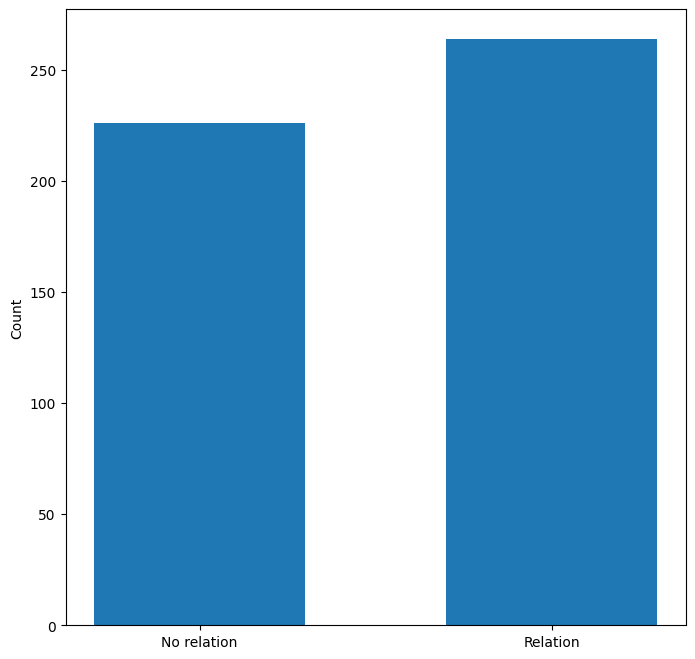

In [12]:
using PyPlot
fig, ax = subplots(figsize=(8,8))
PyPlot.bar([0, 1], [nrow(filter(:relation => ==(0), data)), 
                        nrow(filter(:relation => ==(1), data))],
            width=0.6)
PyPlot.xticks([0,1 ], ["No relation", "Relation"])
PyPlot.ylabel("Count")
PyPlot.savefig("hist.png");

In [13]:
atoms = data[:, :Atoms];

In [14]:
atoms_dict = Dict()
for article in atoms
    for atom in article
        if !(atom in keys(atoms_dict))
            atoms_dict[atom] = 1
        else
            atoms_dict[atom] += 1
        end
    end
end

In [15]:
atoms_dict

Dict{Any, Any} with 6 entries:
  "B" => 165
  "J" => 23
  "M" => 657
  "C" => 1992
  "P" => 635
  "T" => 489

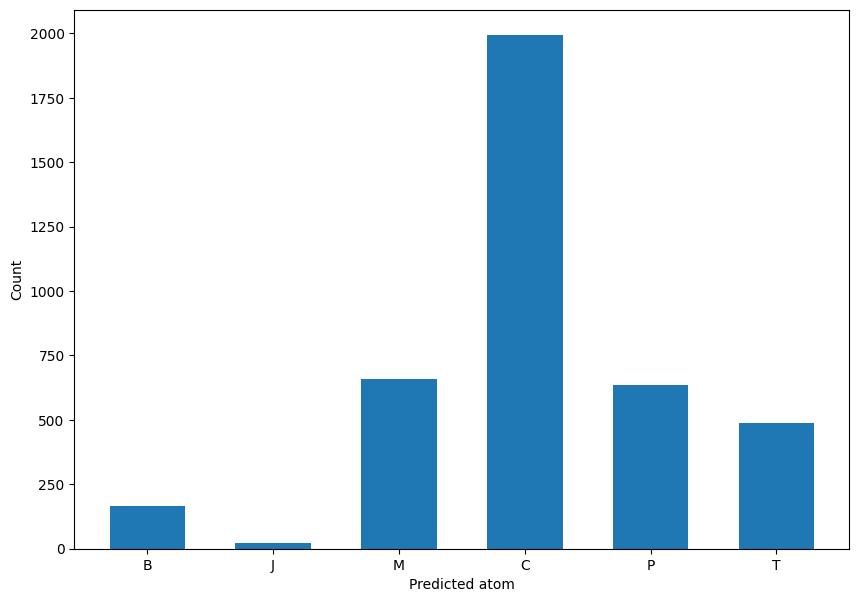

In [16]:
fig, ax = subplots(figsize=(10,7))
PyPlot.bar([1,2,3,4,5,6], [value for value in values(atoms_dict)],
            width=0.6)
PyPlot.ylabel("Count")
PyPlot.xticks([1,2,3,4,5,6], [key for key in keys(atoms_dict)])
PyPlot.xlabel("Predicted atom")
PyPlot.savefig("atoms.png");

In [17]:
# predicates = ["dips", "rebounds", "firms"]
predicates = ["dips", "rebounds", "firms", "posts", 
              "edges", "hikes", "ticks", "struggles", "ends"]
currencies = ["pound", "dollar", "sterling", "euro", "dollar", "lira", "aussie",
              "gbpusd", "gbp", "usdcad", "sterlin", "myanmar", "yuan", "zloty", "forint",
              "yen", "usd/cad", "ruble", "lebanon's", "rouble", "swiss", "rupee",
              "eurusd"];

In [18]:
function get_hg_tokens(text, atoms, currencies=[], predicates=[])
    doc = nlp(text)
#     hg, tokens = nothing
    try
        for (i, token) in enumerate(doc)
#             if lowercase(token.text) in currencies
#                 atoms[i] = "C"
#             end
#             if lowercase(token.text) in predicates
#                 atoms[i] = "P"
#             end
        end
        beta(patterns, doc, atoms)
    catch e
        return nothing
    end
#     return hg, tokens
end

get_hg_tokens (generic function with 3 methods)

In [19]:
function model_1(currencies_list, article)
    if any(y -> occursin(y, lowercase(article)), currencies_list)
        return 1
    else
        return 0
    end
end     

model_1 (generic function with 1 method)

In [20]:
function model_2(currencies_list, article)
    output = 0
    currencies_indexes = []
    doc = nlp(article)
    for (i, token) in enumerate(doc)
        if lowercase(token.text) in currencies_list
            append!(currencies_indexes, i)
        end
    end
    if length(doc) > 3
        for i in currencies_indexes
            if length(doc) > i
                if doc[i+1].pos_ == "VERB"
                    output = 1
                end
            end
        end
    end
    return output
end   

model_2 (generic function with 1 method)

In [21]:
function check_curr(token, currencies_list)
    curr_check = lowercase(token.text) in currencies_list
    return curr_check
end 

check_curr (generic function with 1 method)

In [22]:
x = ["to"]
any(x -> lowercase(x) in ["to", "for"], x)

true

In [23]:
function check_connector(doc, atoms)
#     last_tokens = input[1]
#     t_index = findall(x->x == "T", last_tokens)
#     if length(t_index) == 0
#         return true
#     else
#         t_texts = []
#         for token in input[2][t_index]
#             try
#                 append!(t_texts, [token.text])
#             catch e
#             end
#         end
#         if any(y-> lowercase(y) in ["to", "for"], t_texts)
#             return false
#         else
#             return true
#         end
#     end
    t_index = findall(x->x == "T", atoms)
    texts = [token.text for token in doc]
    if length(t_index) == 0
        return false
    else
        t_texts = texts[t_index]
        if all(y -> lowercase(y) in ["to", "for", "below", "near", "off"], t_texts)
            return false
        else
            return true
        end
    end
end

check_connector (generic function with 1 method)

In [24]:
function model_3(article, atoms, currencies_list, predicates)
    output = 0
    doc = nlp(article)
    out = get_hg_tokens(article, atoms, currencies_list, predicates)
#     if (!(out == nothing) & (any(y -> occursin(y, lowercase(article)), currencies_list)))
    if !(out == nothing)
        conn = check_connector(doc, atoms)
        indexes = findall(x -> x in ['S', 'R'], out[3])
        for index in indexes
            relations = findall(x -> x==1, out[1][:, index])
            if (length(relations) > 3) & (conn) 
                for word in relations
                    curr = check_curr(doc[word], currencies_list)
                    if curr
#                         conn = check_connector(out[2][index-1])
#                         if conn
#                             return 1
#                         else
#                             return 0
#                         end
                        return 1
                    end
                end
            end
        end
    end
    return 0
end

model_3 (generic function with 1 method)

In [25]:
insertcols!(data, 4, :Model1 => 0, :Model2 => 0, :Model3 => 0);

In [26]:
for row in eachrow(data)
    row.Model1 = model_1(currencies, row.Article)
    row.Model2 = model_2(currencies, row.Article)
    row.Model3 = model_3(row.Article, row.Atoms, currencies, predicates)
end

In [62]:
function evaluate(model)
    tp = nrow(filter(row -> (row[model] == 1) & (row["relation"] == 1), data))
    fn = nrow(filter(row -> (row[model] == 0) & (row["relation"] == 1), data))
    fp = nrow(filter(row -> (row[model] == 1) & (row["relation"] == 0), data))
    tn = nrow(filter(row -> (row[model] == 0) & (row["relation"] == 0), data))
    acc = (tp + tn)/(tp+fn+fp+tn)
    er = (fp+fn)/(tp+fp+tn+fn)
    sn = tp/(tp+fn)
    sp = tn/(tn+fp)
    p = tp/(tp+fp)
    r = tp/(tp+fn)
    fm = (2*p*r)/(p+r)
    println("Accuracy: ", acc)
    println("Error rate: ", er)
    println("Sensitivity: ", sn)
    println("Specificity: ", sp)
    println("Precision: ", p)
    println("Recall: ", r)
    println("F1 score: ", fm)
end

evaluate (generic function with 1 method)

In [63]:
evaluate("Model1")

Accuracy: 0.8530612244897959
Error rate: 0.1469387755102041
Sensitivity: 1.0
Specificity: 0.6814159292035398
Precision: 0.7857142857142857
Recall: 1.0
F1 score: 0.88


In [64]:
evaluate("Model2")

Accuracy: 0.7857142857142857
Error rate: 0.21428571428571427
Sensitivity: 0.7083333333333334
Specificity: 0.8761061946902655
Precision: 0.8697674418604651
Recall: 0.7083333333333334
F1 score: 0.7807933194154487


In [65]:
evaluate("Model3")

Accuracy: 0.9224489795918367
Error rate: 0.07755102040816327
Sensitivity: 0.9393939393939394
Specificity: 0.9026548672566371
Precision: 0.9185185185185185
Recall: 0.9393939393939394
F1 score: 0.9288389513108615


In [51]:
false_negative = filter(row -> (row["Model3"] == 1) & (row["relation"] == 0), data)

,Article,Atoms,relation,Model1,Model2,Model3
,String,Array…,Int64,Int64,Int64,Int64
1,GBPUSD working on its 3rd day higher but the going is relatively slow,"[""C"", ""P"", ""T"", ""C"", ""M"", ""C"", ""M"", ""J"", ""M"", ""C"", ""P"", ""M"", ""C""]",0,1,1,1
2,EURUSD remains relatively contained although higher on the day,"[""C"", ""P"", ""M"", ""M"", ""T"", ""C"", ""B"", ""M"", ""C""]",0,1,1,1
3,Cuban peso in free fall against the dollar,"[""M"", ""C"", ""T"", ""M"", ""C"", ""B"", ""M"", ""C""]",0,1,0,1
4,Republican senator urges US to monitor China's digital yuan push during Olympics,"[""M"", ""C"", ""P"", ""C"", ""M"", ""P"", ""C"", ""B"", ""M"", ""C"", ""C"", ""T"", ""C""]",0,1,0,1
5,HSBC Strategist Sees Bullish Pound Risks Going Into BOE Meeting,"[""C"", ""C"", ""P"", ""M"", ""C"", ""C"", ""P"", ""T"", ""C"", ""C""]",0,1,0,1
6,Dollar on track for best year since 2015,"[""C"", ""T"", ""C"", ""B"", ""M"", ""C"", ""B"", ""C""]",0,1,0,1
7,Turkish Lira Extends Selloff Past 14 Per Dollar to Record Low,"[""M"", ""C"", ""P"", ""C"", ""T"", ""C"", ""B"", ""C"", ""T"", ""M"", ""C""]",0,1,1,1
8,Remains Near Over Four Year High Versus Yen,"[""P"", ""M"", ""M"", ""C"", ""C"", ""M"", ""T"", ""C""]",0,1,0,1
9,Yen Weakens Past Key 115 Level for First Time in Four Years,"[""C"", ""P"", ""T"", ""M"", ""M"", ""C"", ""T"", ""M"", ""C"", ""B"", ""C"", ""C""]",0,1,1,1


In [95]:
hg, edges, atoms = get_hg_tokens(false_negative[6, 1], false_negative[6, 2], currencies, predicates);

In [96]:
atoms

2-element Vector{Any}:
 "C"
 'R': ASCII/Unicode U+0052 (category Lu: Letter, uppercase)

In [97]:
edges

Dict{Int64, Tuple{Vector{String}, Vector{PyObject}}} with 3 entries:
  0 => (["C", "C", "P", "C"], [PyObject BoE, PyObject Talk, PyObject Lifts, PyObject Sterlin])
  2 => (["R"], [PyObject [[BoE, Talk], Lifts, Sterlin]])
  1 => (["C", "P", "C"], [PyObject [BoE, Talk], PyObject Lifts, PyObject Sterlin])

In [335]:
edges[4]

(["S"], PyObject[PyObject [[[Lira, Slumps], to], [New, Low]]])

In [339]:
check_connector(edges[2])

[2]PyObject to
false

false